# Calculate Atmospheric attenuation according to ITU-R P.676 (10)

## License

```
Calculate Atmospheric attenuation according to ITU-R P.676 (10).
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycraf import atm
from pycraf import conversions as cnv
from astropy import units as u

## Preparatory: Atmospheric profiles according to ITU R-P.835 (5)

To calculate atmospheric attenuation (by oxygen and water), it is necessary to know the pressure, temperature and water content of the atmospheric layer(s) along the propagating path. For Earth-space paths this means that the height profiles of the three quantities must be known. Furthermore, for accurate raytracing, refraction must be dealt with. Usually this is done by assuming a hard boundary between two adjacent layers having different physical conditions and applying Snells law. The refractive index can be derived from temperature, total pressure and water pressure (which is usually a small fraction of total pressure, because water has much smaller scale heights).

From ITU-R P.453 (10) various helper functions are derived, to compute refractive index, or water vapor pressure from total pressure and temperature (this assumes thermodynamic equilibrium, which might not be present in certain layers, so be careful).

### Standard profile

The *standard profile* represents a typical height profile as averaged over many different environmental conditions and locations.

#### Example: standard height profile plot

In [3]:
# define height grid
height_grid = np.arange(0, 85, 0.1) * u.km

# query profile_standard function (returns a namedtuple)
atm_hprof = atm.profile_standard(height_grid)

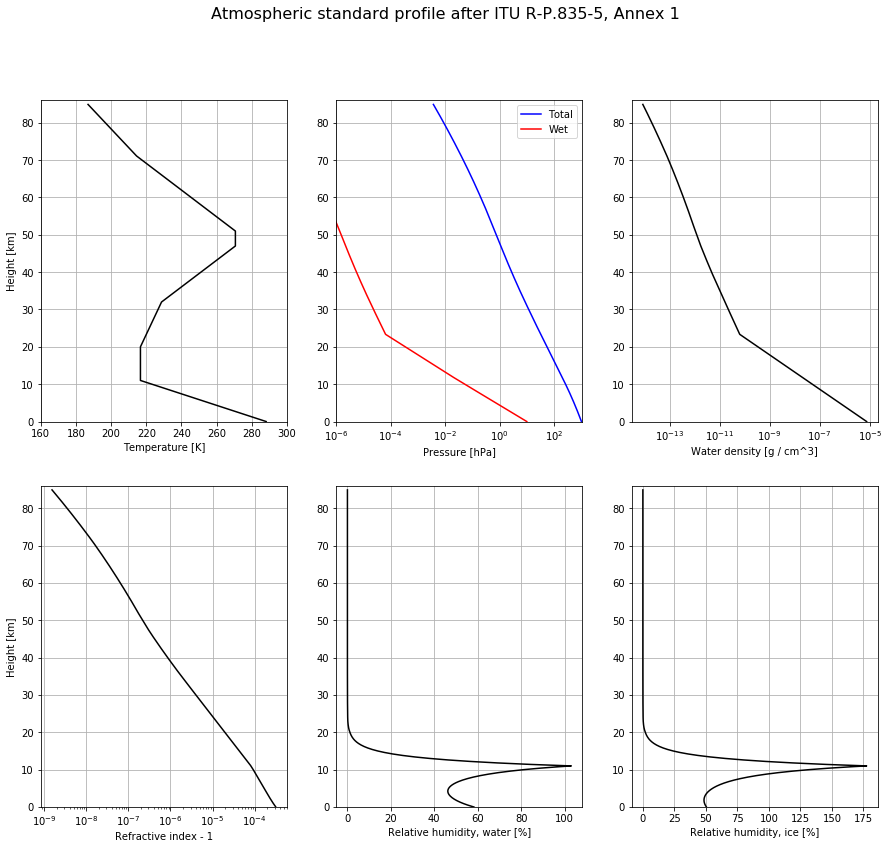

In [4]:
# Plot various quantities
_heights = height_grid.to(u.km).value

plt.close()
fig, axes = plt.subplots(2, 3, figsize=(15, 13))
axes[0, 0].plot(atm_hprof.temperature.to(u.K).value, _heights, 'k-')
axes[0, 0].set_xlabel('Temperature [K]')
axes[0, 0].set_xlim((160, 300))
axes[0, 1].plot(atm_hprof.pressure.to(u.hPa).value, _heights, 'b-', label='Total')
axes[0, 1].plot(atm_hprof.pressure_water.to(u.hPa).value, _heights, 'r-', label='Wet')
axes[0, 1].legend(
    *axes[0, 1].get_legend_handles_labels(),
    loc='upper right', fontsize=10
    )
axes[0, 1].set_xlabel('Pressure [hPa]')
axes[0, 1].semilogx()
axes[0, 1].set_xlim((1.e-6, 1100))
axes[0, 2].plot(atm_hprof.rho_water.to(u.g / u.cm ** 3).value, _heights, 'k-')
axes[0, 2].set_xlabel('Water density [g / cm^3]')
axes[0, 2].semilogx()
#ax3.set_xlim((1.e-3, 1100))
axes[1, 0].plot(atm_hprof.ref_index.to(cnv.dimless).value - 1., _heights, 'k-')
axes[1, 0].set_xlabel('Refractive index - 1')
axes[1, 0].semilogx()
#ax3.set_xlim((1.e-3, 1100))
axes[1, 1].plot(atm_hprof.humidity_water.to(u.percent).value, _heights, 'k-')
axes[1, 1].set_xlabel('Relative humidity, water [%]')
axes[1, 2].plot(atm_hprof.humidity_ice.to(u.percent).value, _heights, 'k-')
axes[1, 2].set_xlabel('Relative humidity, ice [%]')
for idx, ax in enumerate(axes.flat):
    ax.set_ylim((0, 86))
    if idx % 3 == 0:
        ax.set_ylabel('Height [km]')
    ax.grid()


fig.suptitle('Atmospheric standard profile after ITU R-P.835-5, Annex 1', fontsize=16)
plt.show()

### Specialized profiles

In Annex 2 of ITU R-P.835, five more profiles are defined
- Low latitude, $\vert\varphi\vert < 22^\circ$
- Mid latitude (Summer, Winter), $22^\circ \leq \vert\varphi\vert \leq 45^\circ$
- High latitude (Summer, Winter), $\vert\varphi\vert > 45^\circ$

Like for the standard profile, the python functions return not only temperature, pressure and water vapor density, but some additional quantities needed for atmospheric attenuation calculations.

#### Example: specialized height profile plots

The following example plots various height profile quantities for the five different models. At the moment it remains unclear to us, what to do, if conditions (e.g., as measured from a weather station for the lowest layer) deviate from these average profiles.

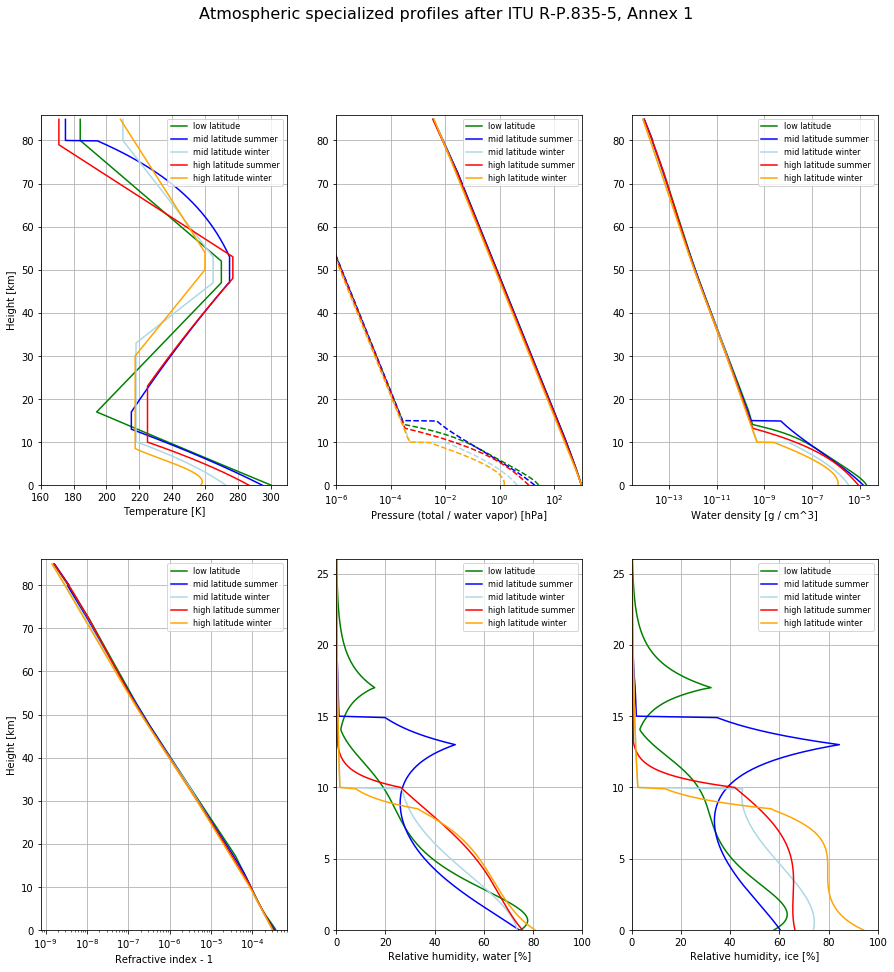

In [5]:
_heights = np.arange(0, 85, 0.1)
height_grid = _heights * u.km

plt.close()
fig, axes = plt.subplots(2, 3, figsize=(15, 15))

for name, func, color in [
        ('low latitude', atm.profile_lowlat, 'g'),
        ('mid latitude summer', atm.profile_midlat_summer, 'b'),
        ('mid latitude winter', atm.profile_midlat_winter, 'lightblue'),
        ('high latitude summer', atm.profile_highlat_summer, 'r'),
        ('high latitude winter', atm.profile_highlat_winter, 'orange'),
        ]:
    atm_hprof = func(height_grid)

    axes[0, 0].plot(atm_hprof.temperature.to(u.K).value, height_grid, '-', color=color, label=name)
    axes[0, 0].set_xlabel('Temperature [K]')
    axes[0, 1].plot(atm_hprof.pressure.to(u.hPa).value, height_grid, '-', color=color, label=name)
    axes[0, 1].plot(atm_hprof.pressure_water.to(u.hPa).value, height_grid, '--', color=color)  #, label=name
    axes[0, 1].set_xlabel('Pressure (total / water vapor) [hPa]')
    axes[0, 2].plot(atm_hprof.rho_water.to(u.g / u.cm ** 3).value, height_grid, '-', color=color, label=name)
    axes[0, 2].set_xlabel('Water density [g / cm^3]')
    axes[1, 0].plot(atm_hprof.ref_index.to(cnv.dimless).value - 1., height_grid, '-', color=color, label=name)
    axes[1, 0].set_xlabel('Refractive index - 1')
    axes[1, 1].plot(atm_hprof.humidity_water.to(u.percent).value, height_grid, '-', color=color, label=name)
    axes[1, 1].set_xlabel('Relative humidity, water [%]')
    axes[1, 2].plot(atm_hprof.humidity_ice.to(u.percent).value, height_grid, '-', color=color, label=name)
    axes[1, 2].set_xlabel('Relative humidity, ice [%]')
    
axes[0, 0].set_xlim((160, 310))
axes[0, 1].set_xlim((1.e-6, 1100))
axes[1, 1].set_xlim((0, 100))
axes[1, 2].set_xlim((0, 100))

axes[0, 1].semilogx()
axes[0, 2].semilogx()
axes[1, 0].semilogx()

for idx, ax in enumerate(axes.flat):
    ax.legend(*ax.get_legend_handles_labels(), loc='upper right', fontsize=8)
    ax.set_ylim((0, 86))
    if idx % 3 == 0:
        ax.set_ylabel('Height [km]')
    ax.grid()

axes[1, 1].set_ylim((0, 26))
axes[1, 2].set_ylim((0, 26))
fig.suptitle('Atmospheric specialized profiles after ITU R-P.835-5, Annex 1', fontsize=16)
plt.show()

## Atmospheric attenuation: ITU-R P.676 (10) Annex 1

For atmospheric attuation, we first need to solve the special case of a path propagating through one specific layer (having just one set of physical conditions, i.e., one temperature, pressure, etc.). If propagation in a Earth-parallel path is of interest, this already solves the problem. However, for tilted paths of propagation and Earth-Space paths, we need to consider the height profiles shown above and ray-trace through layers of atmospheric conditions.

### Specific attenuation
Attenuation is mainly caused by oxygen and water resonance lines, as well as the Debye-absorption of dry air. The resonance lines below 2 THz were copy-pasted from the recommendation into csv-tables for convenience. The first column is the resonance frequency, the other columns describe the lines (strength, width, etc.). For details, we refer to the recommendation itself.

In [6]:
# this looks like the following (ommitting some entries):
print(atm.resonances_oxygen[::5])

[( 50.474214, 9.7500e-01, 9.651,  6.69, 0.,  2.566,  6.85 )
 ( 53.066934, 6.4290e+01, 5.201,  9.06, 0.,  1.349,  6.206)
 ( 55.783815, 9.4530e+02, 2.109, 11.34, 0., -1.172,  6.135)
 ( 58.323877, 2.3637e+03, 0.621, 12.95, 0., -1.932,  0.436)
 ( 60.434778, 2.4380e+03, 0.386, 13.39, 0.,  6.342, -2.825)
 ( 62.997984, 1.4902e+03, 1.654, 11.74, 0.,  1.856, -6.675)
 ( 65.764779, 1.5300e+02, 4.473,  9.55, 0., -2.548, -5.002)
 ( 68.431006, 3.3970e+00, 8.652,  7.17, 0., -2.492, -6.6  )
 (487.249273, 2.3740e+02, 0.049, 16.  , 0.,  0.   ,  0.   )]


In [7]:
print(atm.resonances_water[:5])

[( 22.23508 , 1.13e-01, 2.143, 28.11, 0.69, 4.8 , 1.  )
 ( 67.80396 , 1.20e-03, 8.735, 28.58, 0.69, 4.93, 0.82)
 (119.99594 , 8.00e-04, 8.356, 29.48, 0.7 , 4.78, 0.79)
 (183.310091, 2.42e+00, 0.668, 30.5 , 0.64, 5.3 , 0.85)
 (321.225644, 4.83e-02, 6.181, 23.03, 0.67, 4.69, 0.54)]


Both, oxygen and water vapor lines are defined via an amplitude (aka line strength), $S$, their width, $\Delta f$, and profile shape, $F$. For the shape $F$, which depends on $\Delta F$, there is another parameter $\delta$ which is a kind of correction parameter. The function $N_\mathrm{D}^{\prime\prime}$ returns the Debye absorption spectrum. The following Python helper functions implement this.

#### Examples

In [8]:
# Example: Standard atmosphere
_freqs = np.arange(1, 1000, 1)
freq_grid = _freqs * u.GHz
total_pressure = 1013 * u.hPa
temperature = 290 * u.K
rho_water = 7.5 * u.g / u.m ** 3

pressure_water = atm.pressure_water_from_rho_water(temperature, rho_water)
pressure_dry = total_pressure - pressure_water

print(
    'Oxygen pressure: {:.2f}, '
    'Water vapor partial pressure: {:.2f}'.format(
        pressure_dry, pressure_water
    ))

Oxygen pressure: 1002.96 hPa, Water vapor partial pressure: 10.04 hPa


In [9]:
atten_dry, atten_wet = atm.atten_specific_annex1(
    freq_grid, pressure_dry, pressure_water, temperature
    )
atten_tot = atten_dry + atten_wet

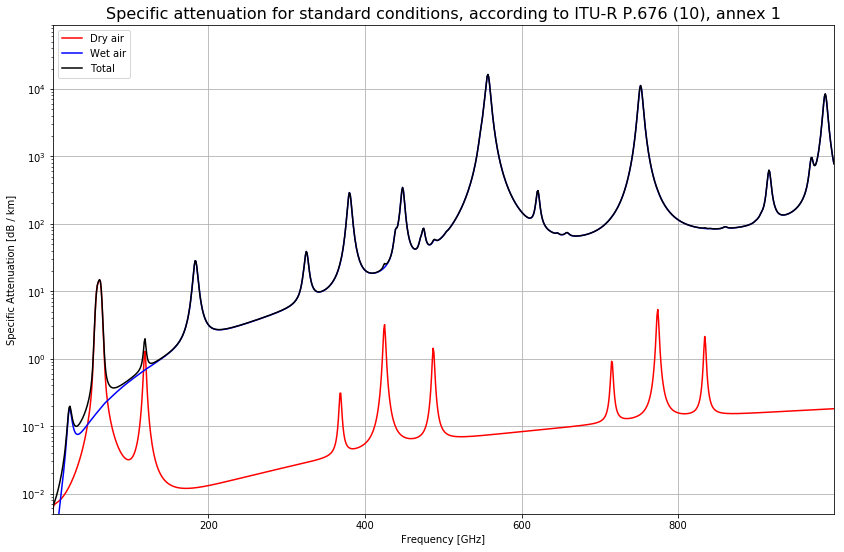

In [10]:
plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, atten_dry.to(cnv.dB / u.km).value, 'r-', label='Dry air')
plt.plot(_freqs, atten_wet.to(cnv.dB / u.km).value, 'b-', label='Wet air')
plt.plot(_freqs, atten_tot.to(cnv.dB / u.km).value, 'k-', label='Total')
plt.semilogy()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Specific Attenuation [dB / km]')
plt.xlim((1, 999))
plt.ylim((5.e-3, 0.9e5))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title(
    'Specific attenuation for standard conditions, according to ITU-R P.676 (10), annex 1',
    fontsize=16
    )
plt.show()

At large heights (small pressure) the oxygen resonances are "resolved":

In [11]:
# Example: Large height
_freqs = np.arange(50, 70, 0.01)
freq_grid = _freqs * u.GHz
height = 20. * u.km
atm_height_profile = atm.profile_highlat_summer(height)
temperature = atm_height_profile.temperature
total_pressure = atm_height_profile.pressure
pressure_water = atm_height_profile.pressure_water
pressure_dry = total_pressure - pressure_water

print(
    'Oxygen pressure: {:.2f}, '
    'Water vapor partial pressure: {:.4f}'.format(
        pressure_dry, pressure_water
    ))

atten_dry, atten_wet = atm.atten_specific_annex1(
    freq_grid, pressure_dry, pressure_water, temperature
    )

Oxygen pressure: 61.99 hPa, Water vapor partial pressure: 0.0001 hPa


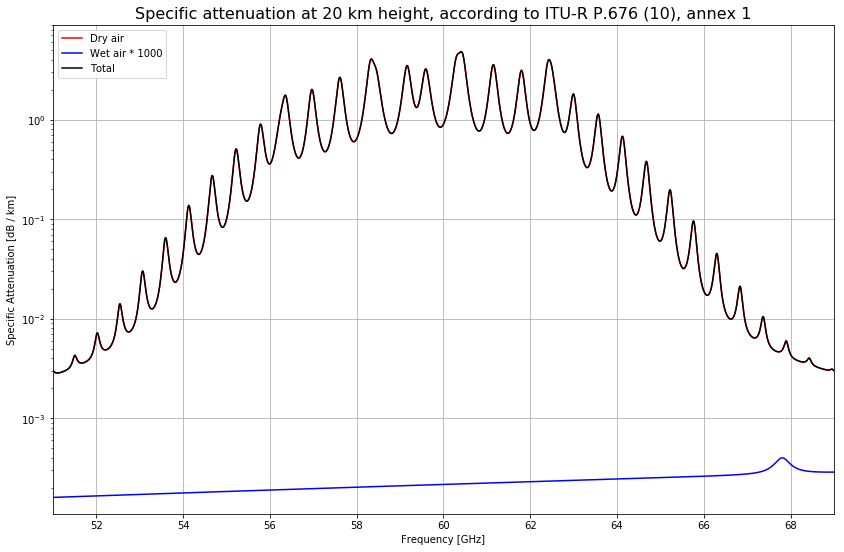

In [12]:
plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, atten_dry.to(cnv.dB / u.km).value, 'r-', label='Dry air')
plt.plot(_freqs, atten_wet.to(cnv.dB / u.km).value * 1000, 'b-', label='Wet air * 1000')
plt.plot(_freqs, (atten_dry + atten_wet).to(cnv.dB / u.km).value, 'k-', label='Total')
plt.semilogy()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Specific Attenuation [dB / km]')
plt.xlim((51, 69))
plt.ylim((1.1e-4, 9e0))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title(
    'Specific attenuation at 20 km height, according to ITU-R P.676 (10), annex 1',
    fontsize=16
    )
plt.show()

### Path attenuation

Note, to convert between attenuation, $\gamma$, and (zenith!) opacity, $\tau$, use

\begin{eqnarray}
\gamma [\mathrm{dB}] &=& 10\log_{10} \gamma\\
\gamma &=& 10^{\gamma [\mathrm{dB}] / 10}\\
\gamma &=& e^{-\tau\cdot \mathrm{AM}},\qquad \mathrm{AM}=\frac{1}{\sin\delta}\\
\tau &=& -\frac{1}{\mathrm{AM}}\ln\gamma
\end{eqnarray}

#### Terrestrial paths

This assumes that only one atmospheric layer (i.e., a single set of pressures/temperatures) is involved. Total attenuation is simply the product of path length with specific attenuation.

#### Slant paths
Calculate total attenuation for an arbitrary path through Earth's atmosphere by raytracing through multiple atmospheric layers, each having a certain refractive index. Note, that this can lead to unexpected behavior, as demonstrated further below (see "Caustics"). Pycraf also calculates the equivalent blackbody radiation of the atmosphere. Each layer contributes to Tebb (multiply its temperature with absorption coefficient, $\kappa=1-\gamma$) but attenuates the radiation of all previous layers. Another auxillary quantity that pycraf provides is the refraction angle, the amount of bending the ray experiences.

The helper function 'raytrace_path' determines the path of propagation sent out with a certain elevation angle (and optionally a maximal length). This is later needed to calculate the total path attenuation. 

Before we can do this, however, we need to setup a cache (dictionary) with the `atm_layers` function, which contains the necessary physical quantities for each layer, most importantly the layer heights and refractive indices. These are not frequency-dependent (at least not in P.676), but for efficiency, also the specific indices are stored. For now, we are not interested in that yet, and can use any frequency.

In [13]:
atm_layers_cache = atm.atm_layers([1] * u.GHz, atm.profile_highlat_winter)

Plotting example rays:

total path length 1: 1000.0
total path length 2: 230.0
total path length 3: 300.0
total path length 4:  71.0


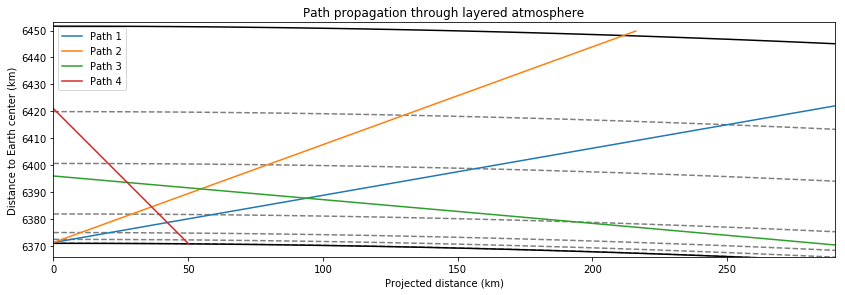

In [14]:
plt.close()
fig = plt.figure(figsize=(14, 6))

# to plot the atmospheric layers, we need to access the layers_cache:
a_e = atm.EARTH_RADIUS
layer_angles = np.arange(0, 0.1, 1e-3)
layer_radii = atm_layers_cache['radii']
bottom, top = layer_radii[[0, 900]]
plt.plot(bottom * np.sin(layer_angles), bottom * np.cos(layer_angles), 'k-')
plt.plot(top * np.sin(layer_angles), top * np.cos(layer_angles), 'k-')
for r in layer_radii[[200, 500, 600, 700, 800, 850]]:
    plt.plot(r * np.sin(layer_angles), r * np.cos(layer_angles), 'k--', alpha=0.5)

for path_num, elevation, obs_alt, max_path_length in zip(
        [1, 2, 3, 4],
        [10, 20, -5, -45] * u.deg,
        [300, 300, 25000, 50000] * u.m,
        [1000, 230, 300, 1000] * u.km,
        ):

    path_params, _, refraction = atm.raytrace_path(
        elevation, obs_alt, atm_layers_cache,
        max_path_length=max_path_length,
        )

    print('total path length {:d}: {:5.1f}'.format(
        path_num, np.sum(path_params.a_n)
        ))

    radii = path_params.r_n
    angle = path_params.delta_n
    x, y = radii * np.sin(angle), radii * np.cos(angle)
    plt.plot(x, y, '-', label='Path {:d}'.format(path_num))

plt.legend(*plt.gca().get_legend_handles_labels())
plt.xlim((0, 290))
plt.ylim((a_e - 5, 6453))
plt.title('Path propagation through layered atmosphere')
plt.xlabel('Projected distance (km)')
plt.ylabel('Distance to Earth center (km)')
plt.gca().set_aspect('equal')
plt.show()

Note, how the Path 4 stops before the maximal path length was reached, as it hit the ground. For paths that go into space, a layer with refractive index of One was added (having zero path attenuation). Therefore, with this functionality, one could work out paths to satellites (but you'd need to apply the proper coordinate system transformation).

For some applications, one may only be interested in the endpoint of a certain path. For this, there is a function similar to `raytrace_path`:

In [15]:
elevation = -1 * u.deg
obs_alt = 10 * u.m
max_path_length = 20 * u.km
# for a description of the member variables, see pycraf manual
atm.path_endpoint(
    elevation, obs_alt, atm_layers_cache,
    max_path_length=max_path_length,
    )

PathEndpoint(a_n=<Quantity 0.00575207 km>, r_n=<Quantity 6371. km>, h_n=<Quantity 0. km>, x_n=<Quantity 0.5740135 km>, y_n=<Quantity 6370.99997414 km>, alpha_n=<Quantity 1.58818179 rad>, delta_n=<Quantity 9.00978654e-05 rad>, layer_idx=1, path_length=<Quantity 0.57410105 km>, nsteps=70, refraction=<Quantity -0.00127604 deg>, is_space_path=False)

This can be useful to make a plot of refraction angles versus elevation.

In [16]:
elevations = np.arange(0.5, 90, 1)
obs_alt = 100 * u.m
refractions = np.array([
    atm.path_endpoint(
        elev * u.deg, obs_alt, atm_layers_cache,
        ).refraction.to(u.arcsec).value
    for elev in elevations
    ])

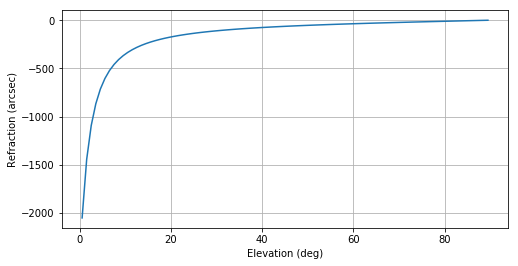

In [17]:
plt.close()
fig = plt.figure(figsize=(8, 4))
plt.plot(elevations, refractions, '-')
plt.xlabel('Elevation (deg)')
plt.ylabel('Refraction (arcsec)')
plt.grid()
plt.show()

#### Caustics

The function `path_endpoint` is really useful, because it allows us to find the correct elevation angle to have the path hit a certain point (e.g., a receiver station). Unfortunately, the model of atmospheric layers with discrete refractive indices leads to some unexpected effects. Consider a situation, where multiple rays with slightly different elevation angles are computed:

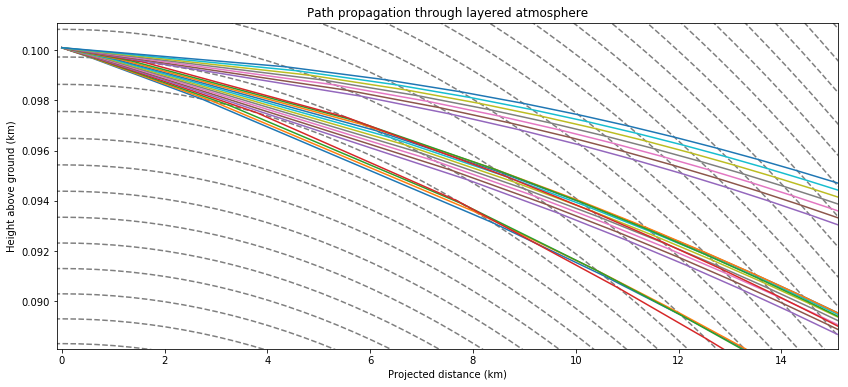

In [18]:
obs_alt = 0.1001 * u.km
e_a = atm.EARTH_RADIUS

layer_angles = np.linspace(-0.001, 0.02, 400)
radii = atm_layers_cache['radii']

plt.close()
fig = plt.figure(figsize=(14, 6))
for r in radii:
    plt.plot(
        r * np.sin(layer_angles),
        r * np.cos(layer_angles) - e_a,
        'k--', alpha=0.5
        )

for elev in np.linspace(-0.04, -0.01, 21):
    path_params, _, _ = atm.raytrace_path(
        elev * u.deg, obs_alt, atm_layers_cache,
        max_path_length=20 * u.km,
        )
    plt.plot(path_params.x_n, path_params.y_n - e_a, '-')

plt.xlim((-0.1, 15.1))
plt.ylim((obs_alt.value - 0.012, obs_alt.value + 0.001))

plt.title('Path propagation through layered atmosphere')
plt.xlabel('Projected distance (km)')
plt.ylabel('Height above ground (km)')
plt.show()

Depending on where exactly the paths hit the boundary of the next layer, a "split" of adjacent rays can occur. These "caustics" have drastic consequences: it is not possible to hit certain points in the atmosphere from a given starting point. This also makes it hard, to have an optimization function find the optimal elevation angle to use for a transmitter-receiver link.

#### Finding the path to a given target

Pycraf comes with a utility function 'find_elevation' that uses [Basinhopping](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html) to find a good (not necessarily best) solution in the non-continuous minimization function (caused by the caustics, see above). This, unfortunately, can be relatively slow depending on path length and properties. It works by specifying the start and end height (above sea level) of the path and the true geographical angular distance between the two (see also [`true_angular_distance` function](https://bwinkel.github.io/pycraf/latest/api/pycraf.geometry.true_angular_distance.html#pycraf.geometry.true_angular_distance)):

In [19]:
tx_alt = 30 * u.m
rx_alt = 2 * u.m
# we can either specify two geographical positions and use true_angular_distance
# function, or for small distances (i.e., small angles) use the following approximation
dist = 5 * u.km
arc_len = np.degrees(dist.value / atm.EARTH_RADIUS) * u.deg
print('arc length {:.4f}'.format(arc_len))

arc length 0.0450 deg


In [20]:
elev_opt, rx_alt_opt = atm.find_elevation(tx_alt, rx_alt, arc_len, atm_layers_cache)
print('Solution: elev = {:.3f} rx_alt: {:.1f}'.format(elev_opt, rx_alt_opt.to(u.m)))

Solution: elev = -0.338 deg rx_alt: 2.0 m


#### Path attenuation

Now do the path propagation calculations.

Refraction for Winter, Elevation: 90 deg: -0.0 arcsec
Refraction for Summer, Elevation: 90 deg: -0.0 arcsec
Refraction for Winter, Elevation: 15 deg: -228.6 arcsec
Refraction for Summer, Elevation: 15 deg: -237.9 arcsec


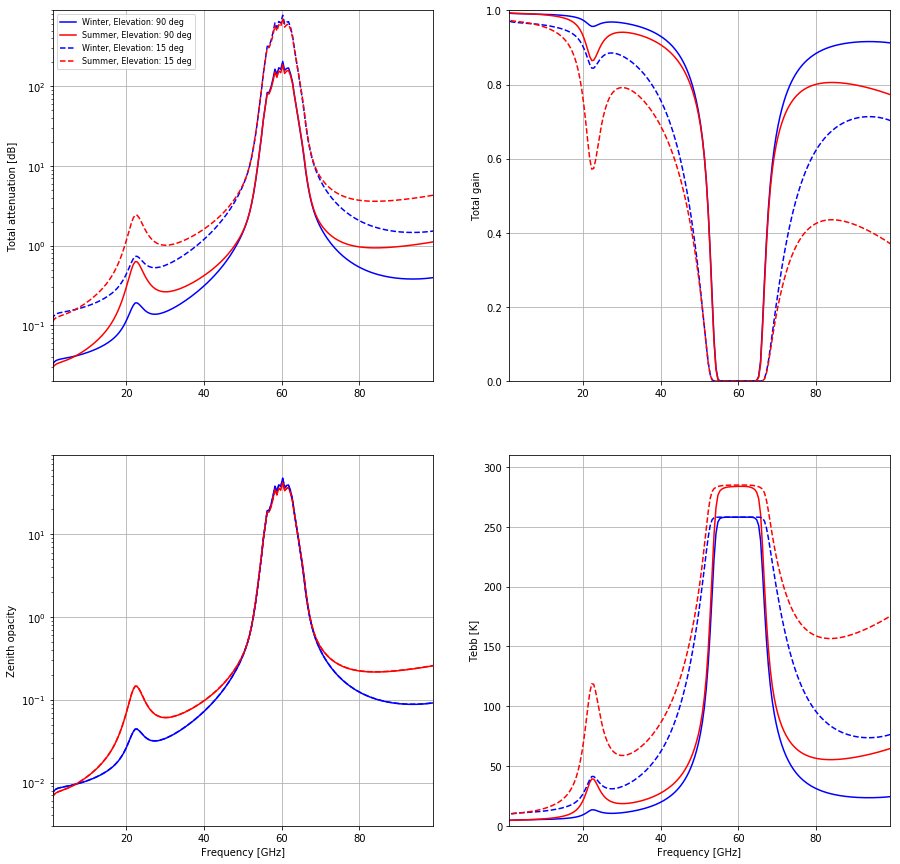

In [21]:
obs_alt = 300 * u.m
_freqs = np.arange(0.25, 100, 0.5)
freq_grid = _freqs * u.GHz

cases = [
    # elevation, profile, label, linestyle
    (90 * u.deg, atm.profile_highlat_winter, 'Winter, Elevation: 90 deg', 'b-'),
    (90 * u.deg, atm.profile_highlat_summer, 'Summer, Elevation: 90 deg', 'r-'),
    (15 * u.deg, atm.profile_highlat_winter, 'Winter, Elevation: 15 deg', 'b--'),
    (15 * u.deg, atm.profile_highlat_summer, 'Summer, Elevation: 15 deg', 'r--'),
    ]

plt.close()
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for elev, profile, label, linestyle in cases:
    
    atm_layers_cache = atm.atm_layers(freq_grid, profile)
    total_atten, refraction, tebb = atm.atten_slant_annex1(
        elev, obs_alt, atm_layers_cache, t_bg=2.73 * u.K
        )
    opacity = atm.opacity_from_atten(total_atten, elev)

    print('Refraction for {}: {:.1f}'.format(label, refraction.to(u.arcsec)))

    axes[0, 0].plot(_freqs, total_atten.to(cnv.dB).value, linestyle, label=label)
    axes[0, 1].plot(_freqs, (-total_atten).to(cnv.dimless).value, linestyle, label=label)
    axes[1, 0].plot(_freqs, opacity.to(cnv.dimless).value, linestyle, label=label)
    axes[1, 1].plot(_freqs, tebb.to(u.K).value, linestyle, label=label)
    
axes[0, 0].semilogy()
axes[1, 0].semilogy()
axes[0, 0].legend(*axes[0, 0].get_legend_handles_labels(), loc='upper left', fontsize=8)
axes[0, 0].set_ylabel('Total attenuation [dB]')
axes[0, 1].set_ylabel('Total gain')
axes[1, 0].set_ylabel('Zenith opacity')
axes[1, 1].set_ylabel('Tebb [K]')
axes[0, 0].set_ylim((2e-2, 9e2))
axes[0, 1].set_ylim((0, 1))
axes[1, 0].set_ylim((3e-3, 9e1))
axes[1, 1].set_ylim((0, 310))

for idx, ax in enumerate(axes.flat):
    ax.grid()
    ax.set_xlim((1, 99))
    if idx >= 2:
        ax.set_xlabel('Frequency [GHz]')

plt.show()

## Atmospheric attenuation: Annex 2

The numerical routines in Annex 1 are relatively time consuming. For frequencies below 350 GHz, ITU-R P676 (10) therefore provides lower-accuracy but more efficient algorithms that describe the attenuation spectrum via "ad-hoc" functions.

### Specific attenuation

Again, we first need the specific attenuation which describes the attenuation per path length within one fixed atmospheric layer.

#### Example: Comparison Annex 1 vs. Annex 2 for standard atmosphere

In [22]:
# Example: Standard atmosphere
_freqs = np.arange(1, 350, 0.5)
freq_grid = _freqs * u.GHz
total_pressure = 1013 * u.hPa
temperature = 290 * u.K
rho_water = 7.5 * u.g / u.m ** 3
pressure_water = atm.pressure_water_from_rho_water(temperature, rho_water)
pressure_dry = total_pressure - pressure_water
print(
    'Oxygen pressure: {:.2f}, '
    'Water vapor partial pressure: {:.2f}'.format(
        pressure_dry, pressure_water
    ))

atten_dry, atten_wet = atm.atten_specific_annex1(
    freq_grid, pressure_dry, pressure_water, temperature
    )
simple_atten_dry, simple_atten_wet = atm.atten_specific_annex2(
    freq_grid, total_pressure, rho_water, temperature
    )

atten_tot = atten_dry + atten_wet
simple_atten_tot = simple_atten_dry + simple_atten_wet

Oxygen pressure: 1002.96 hPa, Water vapor partial pressure: 10.04 hPa


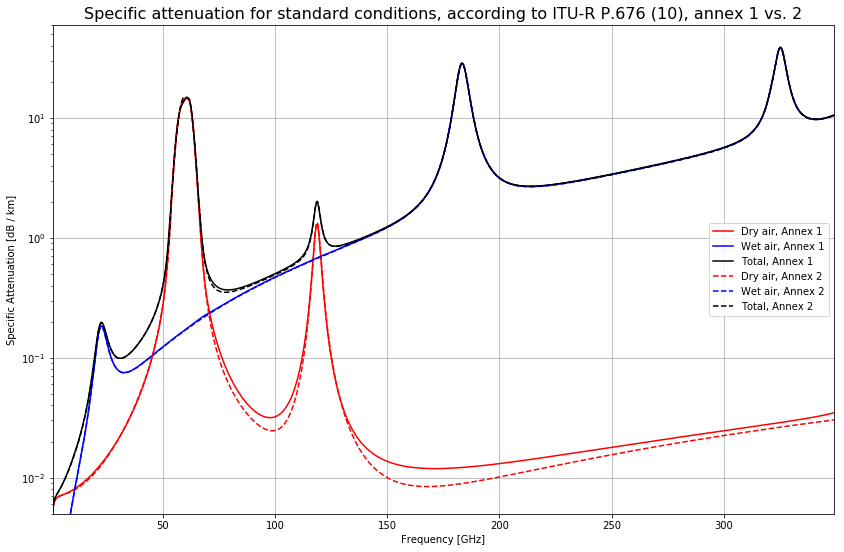

In [23]:
plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, atten_dry.to(cnv.dB / u.km).value, 'r-', label='Dry air, Annex 1')
plt.plot(_freqs, atten_wet.to(cnv.dB / u.km).value, 'b-', label='Wet air, Annex 1')
plt.plot(_freqs, atten_tot.to(cnv.dB / u.km).value, 'k-', label='Total, Annex 1')
plt.plot(_freqs, simple_atten_dry.to(cnv.dB / u.km).value, 'r--', label='Dry air, Annex 2')
plt.plot(_freqs, simple_atten_wet.to(cnv.dB / u.km).value, 'b--', label='Wet air, Annex 2')
plt.plot(_freqs, simple_atten_tot.to(cnv.dB / u.km).value, 'k--', label='Total, Annex 2')
plt.semilogy()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Specific Attenuation [dB / km]')
plt.xlim((1, 349))
plt.ylim((5.e-3, 6e1))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='center right')
plt.title(
    'Specific attenuation for standard conditions, according to ITU-R P.676 (10), annex 1 vs. 2',
    fontsize=16
    )
plt.show()

### Path attenuation
#### Terrestrial paths

Use same formula as for Annex 1.

#### Slant paths

For the simplified algorithm, no raytracing is performed. Instead, one works with an effective atmosphere, consisting of one hypothetical layer. For this, ITU-R P.676-10 provides formulae to calculate the effective path length (for dry and wet air), the so-called equivalent height, that leads to the correct total attenuation if the specific attenuation of the ground is plugged-in.

#### Example: equivalent heights of standard atmosphere

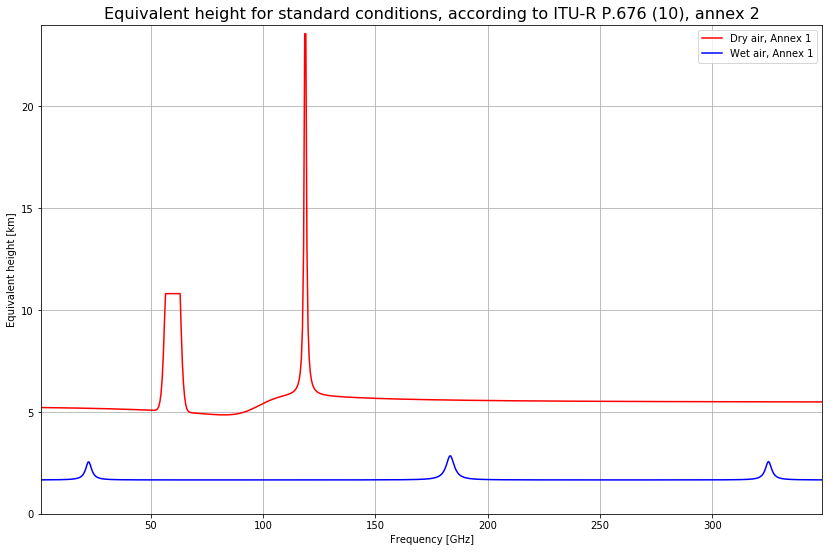

In [24]:
# Example: Standard atmosphere
_freqs = np.arange(1, 350, 0.5)
freq_grid = _freqs * u.GHz
total_pressure = 1013 * u.hPa
h_dry = atm.equivalent_height_dry(freq_grid, total_pressure)
h_wet = atm.equivalent_height_wet(freq_grid, total_pressure)

plt.close()
plt.figure(figsize=(14, 9))
plt.plot(_freqs, h_dry.to(u.km).value, 'r-', label='Dry air, Annex 1')
plt.plot(_freqs, h_wet.to(u.km).value, 'b-', label='Wet air, Annex 1')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Equivalent height [km]')
plt.xlim((1, 349))
plt.ylim((0, 24))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper right')
plt.title(
    'Equivalent height for standard conditions, according to ITU-R P.676 (10), annex 2',
    fontsize=16
    )
plt.show()


With this, the total attenuation is easily calculated, just correct for Air mass (elevation).

#### Example: total path attenuation for standard atmosphere (Annex 1 vs. 2)

In [25]:
# Example 2: Standard atmosphere
_freqs = np.arange(0.5, 350, 0.5)
freq_grid = _freqs * u.GHz
elevation = 15 * u.deg
obs_alt = 0 * u.m

profile_at_0m = atm.profile_standard(0. * u.m)

h_dry = atm.equivalent_height_dry(freq_grid, profile_at_0m.pressure)
h_wet = atm.equivalent_height_wet(freq_grid, profile_at_0m.pressure)

simple_atten_dry, simple_atten_wet = atm.atten_specific_annex2(
    freq_grid, profile_at_0m.pressure, rho_water, temperature
    )
simple_atten_tot_slant = atm.atten_slant_annex2(
    simple_atten_dry, simple_atten_wet, h_dry, h_wet, elevation
    )
simple_opacity_tot_slant = atm.opacity_from_atten(simple_atten_tot_slant, elevation)

atm_layers_cache = atm.atm_layers(freq_grid, atm.profile_standard)
atten_tot_slant, _, _ = atm.atten_slant_annex1(
    elevation, obs_alt, atm_layers_cache, t_bg=2.73 * u.K,
    )
opacity_tot_slant = atm.opacity_from_atten(atten_tot_slant, elevation)

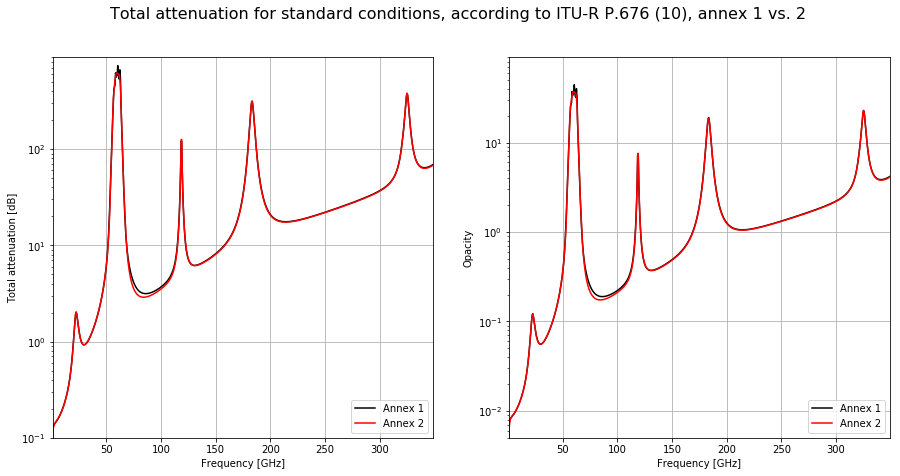

In [26]:
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax1, ax2 = axes
ax1.plot(_freqs, atten_tot_slant.to(cnv.dB).value, 'k-', label='Annex 1')
ax1.plot(_freqs, simple_atten_tot_slant.to(cnv.dB).value, 'r-', label='Annex 2')
ax2.plot(_freqs, opacity_tot_slant.to(cnv.dimless).value, 'k-', label='Annex 1')
ax2.plot(_freqs, simple_opacity_tot_slant.to(cnv.dimless).value, 'r-', label='Annex 2')
ax1.semilogy()
ax1.set_xlim((1, 349))
ax1.set_ylim((1.e-1, 9.e2))
ax2.semilogy()
ax2.set_xlim((1, 349))
ax2.set_ylim((5.e-3, 9.e1))
ax1.grid()
ax2.grid()
ax1.legend(*ax1.get_legend_handles_labels(), loc='lower right')
ax2.legend(*ax2.get_legend_handles_labels(), loc='lower right')
ax1.set_xlabel('Frequency [GHz]')
ax2.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('Total attenuation [dB]')
ax2.set_ylabel('Opacity')
plt.suptitle(
    'Total attenuation for standard conditions, according to ITU-R P.676 (10), annex 1 vs. 2',
    fontsize=16
    )
plt.show()